<a href="https://colab.research.google.com/github/parthkhanna150/MNIST_Image_Classifier/blob/master/hope_to_beat_akshal_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parthkhanna378","key":"ba271b325be1a9c38db29ee662602060"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json
!pip install -q kaggle
!pip install -q kaggle-cli

total 4
-rw------- 1 root root 70 Mar 16 03:49 kaggle.json
    100% |████████████████████████████████| 81kB 3.2MB/s 
    100% |████████████████████████████████| 5.3MB 5.4MB/s 
    100% |████████████████████████████████| 92kB 24.5MB/s 
    100% |████████████████████████████████| 51kB 17.1MB/s 


In [5]:
!kaggle competitions download -c comp-551-w2019-project-3-modified-mnist

  0% 0.00/302k [00:00<?, ?B/s]
100% 302k/302k [00:00<00:00, 40.7MB/s]
 82% 36.0M/44.1M [00:00<00:00, 46.8MB/s]
100% 44.1M/44.1M [00:00<00:00, 89.7MB/s]
 92% 163M/177M [00:01<00:00, 109MB/s] 
100% 177M/177M [00:01<00:00, 118MB/s]
  0% 0.00/67.3k [00:00<?, ?B/s]
100% 67.3k/67.3k [00:00<00:00, 69.4MB/s]


In [6]:
!ls -l --block-size=M

total 222M
-rw-r--r-- 1 root root   1M Mar 16 16:54 kaggle.json
drwxr-xr-x 1 root root   1M Mar  8 17:26 sample_data
-rw-r--r-- 1 root root   1M Mar 16 17:05 sample_submission.csv
-rw-r--r-- 1 root root  45M Mar 16 17:05 test_images.pkl.zip
-rw-r--r-- 1 root root 177M Mar 16 17:05 train_images.pkl.zip
-rw-r--r-- 1 root root   1M Mar 16 17:05 train_labels.csv


In [7]:
!unzip train_images.pkl.zip
!unzip test_images.pkl.zip

Archive:  train_images.pkl.zip
  inflating: train_images.pkl        
Archive:  test_images.pkl.zip
  inflating: test_images.pkl         


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
sns.set(style='white', context='notebook', palette='deep')
import pickle
import csv
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import cv2
import matplotlib.patches as mpatches

from skimage.morphology import label, closing, square
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.transform import resize, rotate
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import threshold_otsu, threshold_local
from skimage.segmentation import clear_border

from sklearn.model_selection import train_test_split

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
infile = open('./train_images.pkl','rb')
train_images = pickle.load(infile)

infile = open('./test_images.pkl','rb')
test_images = pickle.load(infile)

train_labels = pd.read_csv('./train_labels.csv')

In [168]:
train_images.shape

(40000, 64, 64)

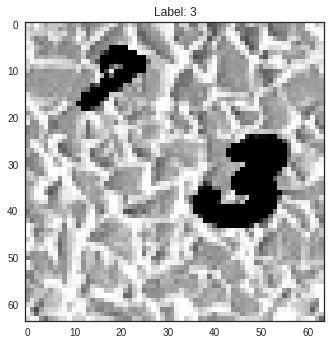

In [169]:
import matplotlib.pyplot as plt

#Let's show image with id 16
img_idx = 200

plt.title('Label: {}'.format(train_labels.iloc[img_idx]['Category']))
plt.imshow(train_images[img_idx])
plt.show()

In [0]:
batch_size = 128
num_classes = 10
epochs = 12
seed = 7
np.random.seed(seed)
img_rows, img_cols = 28, 28

In [0]:
def preprocess(x, imgDim):
    finalData = np.zeros(shape=(x.shape[0], imgDim, imgDim))
    #Loop through every image in provided data
    for i in range(x.shape[0]):
        
        #Binarizing the image
        currImg = np.array(x[i])
        currImg[currImg != 255] = 0 
        #Non-black pixel--> threshold as a 0.
        # img = cv2.imread(,0)
        currImg[currImg == 255] = 1 
        #255 intensity --> threshold as a 1.
        
#         print(currImg.shape)
#         print(type(currImg))
#         currImg = tuple(map(tuple, currImg))
#         kernel = np.ones((5,5),np.uint8)
#         erosion = cv2.erode(currImg, kernel, iterations = 1)
        
#         print(erosion.shape)
#         print(type(erosion))

        binarizedImg = currImg # >= thresh
        
#         print(binarizedImg)
        
        labelledCompImg = label(binarizedImg)  #Labels each connected component in binarized image
        biggestRegion = regionprops(labelledCompImg) #initialize current maximum connected component
        prevLen = 0
        #For every connected component, check if it's the biggest in the image.
        for region in regionprops(labelledCompImg):
            minRow, minCol, maxRow, maxCol = region.bbox #find bounding box
            length = max(abs(minRow-maxRow), abs(minCol-maxCol))
            if length > prevLen: #compare length of bounding boxes in img
                prevLen = length
                biggestRegion = region

        #Isolate the largest component by cropping it's bounding box
        minRow, minCol, maxRow, maxCol = biggestRegion['BoundingBox']
        
        isolatedNum = binarizedImg[min(minRow,maxRow):max(minRow,maxRow), min(minCol,maxCol):max(minCol,maxCol)]
        
        #Transform to new dimensions 28x28
        finalData[i] = resize(isolatedNum, (imgDim,imgDim))
        kernel = np.ones((2,2),np.uint8)
        finalData[i] = cv2.erode(finalData[i], kernel, iterations = 1)

        
        if (i%2000 == 0):
            print("Currently on example #: ", i)
            
    return finalData

In [0]:
yTrain = []
with open("train_labels.csv", "r") as csv_file: #Because this was quicker than Panda
    csv_reader = csv.reader(csv_file, delimiter=',')
    for lines in csv_reader:
        yTrain.append(lines[1])
yTrain.remove('Category')

In [446]:
xTrain = preprocess(train_images, 28) 

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Currently on example #:  0
Currently on example #:  2000
Currently on example #:  4000
Currently on example #:  6000
Currently on example #:  8000
Currently on example #:  10000
Currently on example #:  12000
Currently on example #:  14000
Currently on example #:  16000
Currently on example #:  18000
Currently on example #:  20000
Currently on example #:  22000
Currently on example #:  24000
Currently on example #:  26000
Currently on example #:  28000
Currently on example #:  30000
Currently on example #:  32000
Currently on example #:  34000
Currently on example #:  36000
Currently on example #:  38000


In [0]:
x_train, x_test, y_train, y_test = train_test_split(xTrain, yTrain, test_size=0.1, random_state=seed)

In [0]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


In [449]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (36000, 28, 28, 1)
36000 train samples
4000 test samples


In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


In [0]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=30,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
#0.9355

In [0]:
# import cv2
# img = cv2.imread(,0)
# kernel = np.ones((4,4),np.uint8)
# erosion = cv2.erode(img,kernel,iterations = 1)


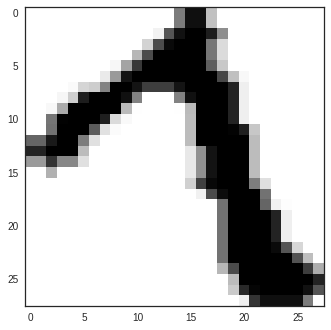

In [450]:
plt.imshow(x_train[10][:,:,0])
# x_train.shape

In [0]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [0]:
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer='adam'

In [0]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [0]:
batch_size = 86
epochs=40

In [0]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
#     width_shift_range = 0.0,
#     height_shift_range = 0.0,
    rotation_range = 40,
    shear_range = 0.05,
    zoom_range = 0.05,
    fill_mode = 'constant',
    cval = 0)

datagen.fit(x_train)


In [0]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 40, validation_data = (x_test,y_test),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])



In [463]:
score = model.evaluate(x_test, y_test)
print()
print('Validation accuracy: ', score[1])

4000/4000 [==============================] - 0s 120us/step

Validation accuracy:  0.9545


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Currently on example #:  0
Currently on example #:  2000
Currently on example #:  4000
Currently on example #:  6000
Currently on example #:  8000
Image  0
Label 9


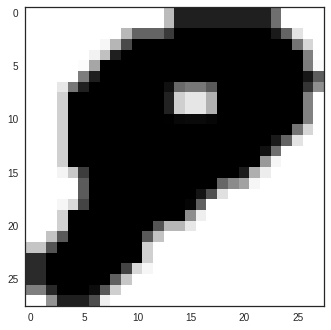

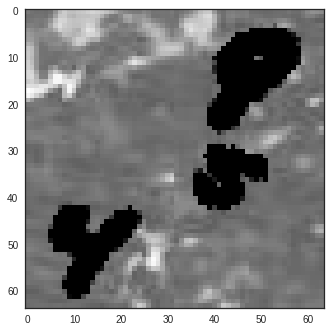

Image  1
Label 4


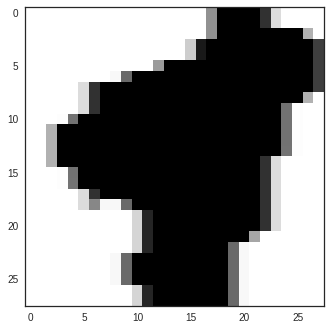

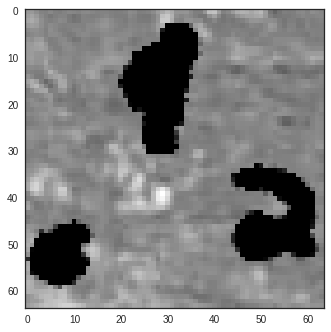

Image  2
Label 2


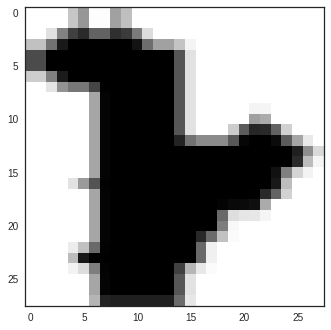

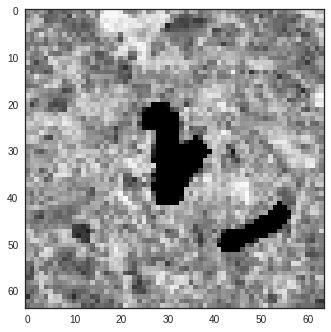

Image  3
Label 2


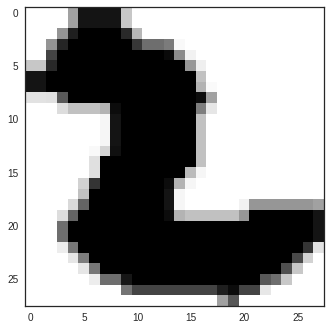

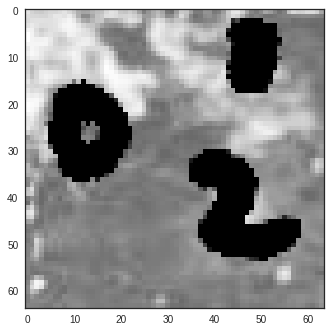

Image  4
Label 2


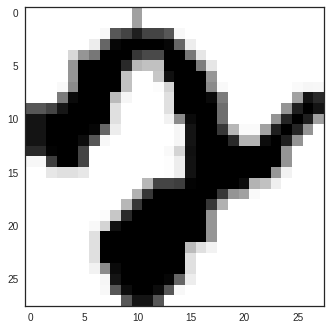

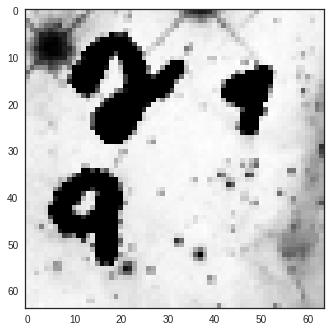

In [464]:
x_Test = preprocess(test_images, 28)
x_Test_r = x_Test.reshape(x_Test.shape[0], 28, 28, 1)
y_Test=model.predict(x_Test_r)
y_pred = np.argmax(y_Test, axis=1)
with open("submission.csv", "w+") as f:
  f.write("Id,Category\n")
  for i in range(y_pred.shape[0]):
    s = "" + str(i) + ',' + str(int(y_pred[i])) + "\n"
    f.write(s)
f.close()
files.download("submission.csv")

import random
#Checking the test predictions 
for i in range (5):
  idx = random.randint(0, y_Test.shape[0])
  print ("Image ", i)
  print ("Label", y_pred[idx])

  plt.imshow(x_Test[idx])
  plt.show()
  plt.imshow(test_images[idx])
  plt.show()


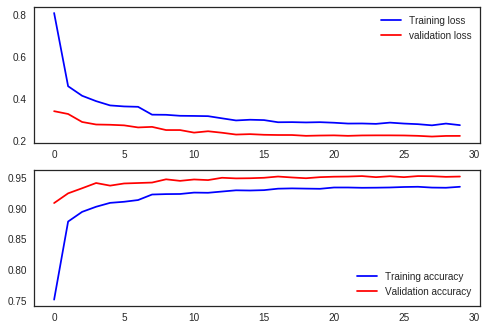

In [170]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


In [199]:
datagen = ImageDataGenerator(
        width_shift_range = 0,
        height_shift_range = 0,
        rotation_range = 24,
        shear_range = 0.0,
        zoom_range = 0.0,
        fill_mode = 'nearest',
        cval = 0
        )  # randomly rotate images in the range (degrees, 0 to 180)

datagen.fit(x_train)

history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 30, validation_data = (x_test,y_test),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])



Epoch 1/30
 - 11s - loss: 0.3627 - acc: 0.9124 - val_loss: 0.2866 - val_acc: 0.9333
Epoch 2/30
 - 10s - loss: 0.3610 - acc: 0.9150 - val_loss: 0.3296 - val_acc: 0.9285
Epoch 3/30
 - 10s - loss: 0.3587 - acc: 0.9167 - val_loss: 0.2817 - val_acc: 0.9382
Epoch 4/30
 - 10s - loss: 0.3577 - acc: 0.9154 - val_loss: 0.3290 - val_acc: 0.9308
Epoch 5/30
 - 10s - loss: 0.3585 - acc: 0.9161 - val_loss: 0.3408 - val_acc: 0.9375
Epoch 6/30
 - 10s - loss: 0.3655 - acc: 0.9150 - val_loss: 0.2973 - val_acc: 0.9385
Epoch 7/30
 - 10s - loss: 0.3585 - acc: 0.9160 - val_loss: 0.2703 - val_acc: 0.9392
Epoch 8/30
 - 10s - loss: 0.3652 - acc: 0.9151 - val_loss: 0.3005 - val_acc: 0.9347
Epoch 9/30
 - 10s - loss: 0.3650 - acc: 0.9148 - val_loss: 0.3056 - val_acc: 0.9392
Epoch 10/30
 - 10s - loss: 0.3719 - acc: 0.9136 - val_loss: 0.2769 - val_acc: 0.9382

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/30
 - 10s - loss: 0.3262 - acc: 0.9237 - val_loss: 0.2785 - val_acc: 